In [1]:
!pip install wandb


In [2]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
import keras
import wandb
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from sklearn.utils import shuffle
from tensorflow.keras.layers import Input, Lambda, MaxPooling2D, BatchNormalization, Dense, Flatten, Activation,Dropout, Conv2D,Layer
from tensorflow.nn import local_response_normalization


In [3]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
dir_path="/kaggle/input/signature-verification-dataset/sign_data"
train_path="/kaggle/input/signature-verification-dataset/sign_data/train"

**Lets visualize the data that we got here**

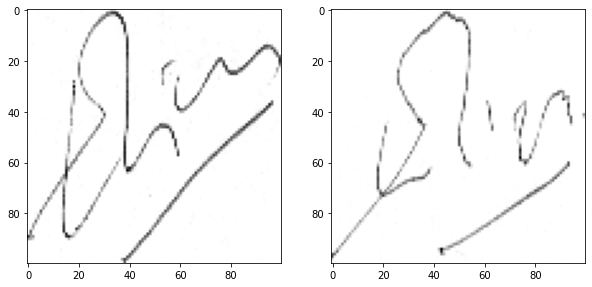

In [5]:
trial_image_forge="/kaggle/input/signature-verification-dataset/sign_data/train/001_forg/0119001_01.png"
trial_image_path="/kaggle/input/signature-verification-dataset/sign_data/train/001/001_01.PNG"
def transform(image):
    """
    inp:img
    convert in to black and white
    resize the image to the dim (100,100)
    return transformed image
    """
    image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    image=cv2.resize(image,(100,100))
    return image

def read_image(path):
    """
    inp:path
    transform
    return image    
    """
    img=cv2.imread(path)
    img=transform(img)
    return img
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(read_image(trial_image_path),cmap="gray")
plt.subplot(1,2,2)
plt.imshow(read_image(trial_image_forge),cmap="gray")

Initially lets not push in the enitre data in out training set since this project is more of an anaytical and we rather want to see the how the feature vector of the distance layer and embedding layer differ before the training and after the training .

So as of now lets only take one or two sygnature types and see how it works

In [6]:
trial_dir=["001","002"]
set_imgs=[]

for name in trial_dir:
    real_path=os.path.join(train_path,name)
    for path in os.listdir(real_path):
        path1=os.path.join(real_path,path)
        forge_path=os.path.join(train_path,name+"_forg")
        for pth in os.listdir(forge_path):
            path2=os.path.join(forge_path,pth)
            set_imgs.append([path1,path2,0])

for name in trial_dir:
    real_path=os.path.join(train_path,name)
    for path in os.listdir(real_path):
        path1=os.path.join(real_path,path)
        count=0
        for pth in os.listdir(real_path):
            path2=os.path.join(real_path,pth)
            count=count+1
            if count<=10:
                set_imgs.append([path1,path2,1])
            else:
                break

                    

In [11]:
##now lets read for pairs of each set of images
total_data=len(set_imgs)

In [8]:
first_imgs=[]
second_imgs=[]
labels=[]

for lst in set_imgs:
    first_imgs.append(read_image(lst[0]))
    second_imgs.append(read_image(lst[1]))
    labels.append(lst[2])
    

In [9]:
from sklearn.utils import shuffle
size=100
first_imgs,second_imgs,labels=shuffle(first_imgs,second_imgs,labels)
first_imgs=np.array(first_imgs).reshape(-1, size,size, 1)/255.0
second_imgs=np.array(second_imgs).reshape(-1, size,size, 1)/255.0
labels=np.array(labels)


In [12]:
run = wandb.init(project='Signature-Verification', group='viz_data')

ds = wandb.Artifact("Signature-Verification_dataset", "dataset")

train_table = wandb.Table(columns=[], data=[])
# Add training data
train_table.add_column('first_image', first_imgs[:total_data])

train_table.add_column('second_image',second_imgs[:total_data])
# Add training label_id
train_table.add_column('label_id', labels[:total_data])


ds['train_data'] = train_table

ds.save()

wandb.finish()


wandb: Currently logged in as: pranay-009. Use `wandb login --relogin` to force relogin


In [13]:
class L1Dist(Layer):
    #developd a custom layer 
    def __init__(self, **kwargs):
        super().__init__()
        
    def call(self, input_embedding, validation_embedding):
        #finding the absolute difference in between the two embeddings
        return tf.math.abs(input_embedding - validation_embedding)

In [14]:
def embedding_model(input_shape):
    lay=Sequential()
    #block1
    lay.add(Conv2D(64,(11,11),activation="relu",strides=1,input_shape=input_shape))
    #lay.add(Lambda(local_response_normalization))
    lay.add(BatchNormalization())
    lay.add(MaxPooling2D((2,2)))
    #block2
    lay.add(Conv2D(128,(5,5),activation="relu",strides=1))
    #lay.add(Lambda(local_response_normalization))
    lay.add(BatchNormalization())
    lay.add(MaxPooling2D((2,2)))
    lay.add(Dropout(0.3))
    #block3
      
    #lay.add(Conv2D(384,(3,3),activation="relu",strides=1))
    lay.add(Conv2D(256,(3,3),activation="relu",strides=1))
    #lay.add(BatchNormalization())
    lay.add(MaxPooling2D((2,2)))
    lay.add(Dropout(0.3))
    
    #block4
    lay.add(Flatten())
    #lay.add(Dense(4096, activation='sigmoid'))
    lay.add(Dense(1028, activation='relu'))
    return lay

    

In [15]:
base_model=embedding_model((100,100,1))

In [16]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 90, 64)        7808      
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 90, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 41, 41, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 41, 41, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 20, 20, 128)       0

In [17]:
inp1=Input(shape=(100,100,1))
inp2=Input(shape=(100,100,1))
embedding1=base_model(inp1)
embedding2=base_model(inp2)
siamese=L1Dist()
distance=siamese(embedding1,embedding2)
classify=Dense(1,activation="sigmoid")(distance)
model=Model(inputs=[inp1,inp2],outputs=classify)


In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 100, 100, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 1028)         21826308    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
l1_dist (L1Dist)                (None, 1028)         0           sequential[0][0]             

In [24]:
configs = dict(
    data_flag = 'Signature',
    image_width = 100,
    image_height = 100,
    batch_size = 32,
    epochs = 5,
    init_learning_rate = 0.001,
    lr_decay_rate = 0.1,
    optimizer = 'adam',
    loss_fn = "binary_crossentropy",
    metrics = ['accuracy'],
)

trial_image,trial_image2,trial_labels=first_imgs[:30],second_imgs[:30],labels[:30]

In [25]:
model.compile(loss="binary_crossentropy", optimizer=optimizers.Adam(learning_rate=0.001)
              ,metrics=["accuracy"])


In [30]:

run = wandb.init(project='Signature-Verification', config=configs, job_type='train')
config = wandb.config

wandb_callback = wandb.keras.WandbCallback(data_type='image',
                               training_data=(trial_image,trial_image2,trial_labels),
                               monitor='val_loss',
                               log_weights=True,
                               log_evaluation=True,
                               )


tf.keras.backend.clear_session()
model.fit([first_imgs,second_imgs],labels,epochs=config.epochs,batch_size=config.batch_size,validation_split=0.2,callbacks=[wandb_callback])



wandb.finish()

wandb: WARNING WandbCallback is unable to read validation_data from trainer and therefore cannot log validation data. Ensure Keras is properly patched by calling `from wandb.keras import WandbCallback` at the top of your script.


Epoch 1/5
24/24 [==============================] - 1s 44ms/step - loss: 0.0163 - accuracy: 0.9974 - val_loss: 2.5138 - val_accuracy: 0.7188


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 2/5
24/24 [==============================] - 1s 40ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 1.6921 - val_accuracy: 0.8490


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 3/5
24/24 [==============================] - 1s 38ms/step - loss: 0.0058 - accuracy: 0.9987 - val_loss: 1.4214 - val_accuracy: 0.8750


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 4/5
24/24 [==============================] - 1s 40ms/step - loss: 0.0049 - accuracy: 0.9987 - val_loss: 0.4259 - val_accuracy: 0.9323


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 5/5
24/24 [==============================] - 1s 37ms/step - loss: 0.0089 - accuracy: 0.9974 - val_loss: 0.2282 - val_accuracy: 0.9375


wandb: WARNING No validation_data set, pass a generator to the callback.


accuracy,▁█▅▅▁
epoch,▁▃▅▆█
loss,█▁▃▂▄
val_accuracy,▁▅▆██
val_loss,█▅▅▂▁
GFLOPS,1.04935
accuracy,0.9974
best_epoch,4
best_val_loss,0.22816
epoch,4
loss,0.00889


In [29]:
wandb.finish()

accuracy,▁▇███
epoch,▁▃▅▆█
loss,█▁▁▁▁
val_accuracy,▁▁▃▇█
val_loss,▇▇▆▁█
GFLOPS,1.04935
accuracy,0.98828
best_epoch,3
best_val_loss,0.50019
epoch,4
loss,0.03565


In [31]:
temp_model=model.layers[:3]


In [32]:
len(temp_model[2](first_imgs[:1]).numpy()[0])

1028

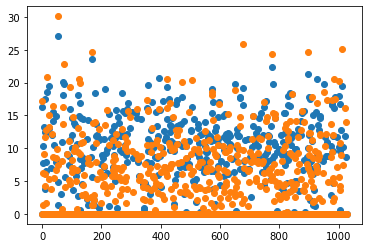

In [33]:
plt.scatter(np.arange(0, 1028, 1),temp_model[2](first_imgs[3:4]).numpy()[0])
plt.scatter(np.arange(0, 1028, 1),temp_model[2](second_imgs[3:4]).numpy()[0])
plt.show()

In [34]:
model.predict([first_imgs[3:4],second_imgs[3:4]])

array([[9.772765e-09]], dtype=float32)

In [35]:
labels[3:4]

array([0])

In [36]:
model([first_imgs[:1],second_imgs[:1]])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2.7344123e-07]], dtype=float32)>

In [37]:
a=temp_model[2](first_imgs[:1]).numpy()
b=temp_model[2](second_imgs[:1]).numpy()
c=temp_model[2](first_imgs[3:4]).numpy()
d=temp_model[2](second_imgs[3:4]).numpy()


In [38]:
model.layers[3](a,b).numpy()[0]

array([3.4926567, 0.       , 1.4619231, ..., 6.236639 , 0.       ,
       0.       ], dtype=float32)

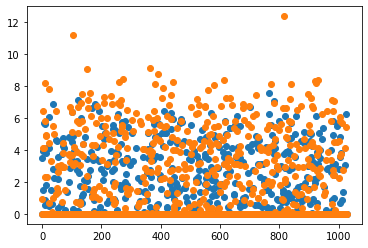

In [39]:
plt.scatter(np.arange(0, 1028, 1),model.layers[3](a,b).numpy()[0])
plt.scatter(np.arange(0, 1028, 1),model.layers[3](c,d).numpy()[0])

In [43]:
tf.__version__

'2.6.4'

In [40]:
wandb.__version__

'0.12.21'